In [1]:
import contextlib
import io
import mysql.connector
import mysql.connector.errors
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
import text2sql.cfg as cfg
import timeit
from text2sql.cfg.parser import text2sqlParser, text2sqlListener, text2sqlLexer
from antlr4.InputStream import InputStream
from antlr4 import ParseTreeWalker, CommonTokenStream
from config import CONFIG
from llm.azure_client import AzureClient

In [2]:
def read_dataset(path: str) -> dict:
    with open(path, 'r') as f:
        lines = f.readlines()
        questions = []
        queries = []
        for line in lines:
            if line.startswith('Vraag: '):
                questions.append(line.replace('Vraag: ', '').strip('\n'))
            elif line.startswith('SQL: '):
                queries.append(line.replace('SQL: ', '').strip('\n'))
    return {'questions': questions, 'queries':queries}

In [3]:
train = read_dataset('./text2sql/datasets/text2sql-trainset.txt')
test = read_dataset('./text2sql/datasets/text2sql-testset.txt')

In [4]:
def load_pickle(file) -> list:
    with open(file, 'rb') as f:
        return pickle.load(f)

In [5]:
results_train_rule_based = load_pickle('text2sql_results/results_train_rule_based.pkl')
results_train_llm_based_zero_shot = load_pickle('text2sql_results/results_train_llm_based_zero_shot.pkl')
results_train_llm_based_few_shot = load_pickle('text2sql_results/results_train_llm_based_few_shot.pkl')
results_test_rule_based = load_pickle('text2sql_results/results_test_rule_based.pkl')
results_test_llm_based_zero_shot = load_pickle('text2sql_results/results_test_llm_based_zero_shot.pkl')
results_test_llm_based_few_shot = load_pickle('text2sql_results/results_test_llm_based_few_shot.pkl')

In [6]:
runtime_train_rule_based = load_pickle('text2sql_results/runtime_train_rule_based.pkl')
runtime_train_llm_based_zero_shot = load_pickle('text2sql_results/runtime_train_llm_based_zero_shot.pkl')
runtime_train_llm_based_few_shot = load_pickle('text2sql_results/runtime_train_llm_based_few_shot.pkl')
runtime_test_rule_based = load_pickle('text2sql_results/runtime_test_rule_based.pkl')
runtime_test_llm_based_zero_shot = load_pickle('text2sql_results/runtime_test_llm_based_zero_shot.pkl')
runtime_test_llm_based_few_shot = load_pickle('text2sql_results/runtime_test_llm_based_few_shot.pkl')

In [7]:
def check_select_columns(hypothesis: str, reference: str) -> bool:
    matched_hypothesis = re.search(r'SELECT(?:DISTINCT)?(?P<columns>.*)(?P<rest>FROM\s?.*)', hypothesis)
    matched_reference = re.search(r'SELECT(?:DISTINCT)?(?P<columns>.*)(?P<rest>FROM\s?.*)', reference)
    if matched_hypothesis and matched_reference:
        columns_hypothesis, rest_hypothesis = matched_hypothesis.groups()
        columns_reference, rest_reference = matched_reference.groups()
        return columns_hypothesis != columns_reference and rest_hypothesis == rest_reference
    return False

def validate_sql(query: str) -> None|str:
    with mysql.connector.connect(**CONFIG['DB']) as connection:
        with connection.cursor(dictionary=True, prepared=True) as cursor:
            try:
                cursor.execute(query)
                cursor.fetchall()
            except mysql.connector.errors.InterfaceError as e:
                return e

In [8]:
def evaluate_outputs(output: list[str], ground_truth: list[str]) -> dict:
    result = {'correct':[], 'different_valid':[], 'syntax_error':[], 'invalid_column':[]}
    for i, (hypothesis, reference) in enumerate(zip(output, ground_truth)):
        if hypothesis.lower().replace(' ', '') == reference.lower().replace(' ', ''):
            result['correct'].append((hypothesis, i))
            continue
        if sql_error := validate_sql(hypothesis):
            if sql_error.msg.startswith('You have an error in your SQL syntax'):
                result['syntax_error'].append((hypothesis, i))
                continue
            if sql_error.msg.startswith('Unknown column'):
                result['invalid_column'].append((hypothesis, i))
                continue
        result['different_valid'].append((hypothesis, i))
    return result

In [9]:
evaluation_rule_based_train = evaluate_outputs(results_train_rule_based, train['queries'])
evaluation_rule_based_test = evaluate_outputs(results_test_rule_based, test['queries'])
evaluation_zero_shot_train = evaluate_outputs(results_train_llm_based_zero_shot, train['queries'])
evaluation_zero_shot_test = evaluate_outputs(results_test_llm_based_zero_shot, test['queries'])
evaluation_few_shot_train = evaluate_outputs(results_train_llm_based_few_shot, train['queries'])
evaluation_few_shot_test = evaluate_outputs(results_test_llm_based_few_shot, test['queries'])

DatabaseError: 2003 (HY000): Can't connect to MySQL server on '127.0.0.1:3306' (111)

In [ ]:
def print_statistics(evaluation_dict, title):
    print(f'Statistics for {title}:')
    print(f'Correct: {len(evaluation_dict['correct'])}')
    print(f'Different but valid: {len(evaluation_dict['different_valid'])}')
    print(f'Syntax error: {len(evaluation_dict['syntax_error'])}')
    print('*'*35)

In [ ]:
print_statistics(evaluation_rule_based_train, 'Rule-based train')
print_statistics(evaluation_rule_based_test, 'Rule-based test')
print_statistics(evaluation_zero_shot_train, 'LLM-based zero-shot train')
print_statistics(evaluation_zero_shot_test, 'LLM-based zero-shot test')
print_statistics(evaluation_few_shot_train, 'LLM-based few-shot train')
print_statistics(evaluation_few_shot_test, 'LLM-based few-shot test')

Statistics for Rule-based train:
Correct: 11
Different but valid: 27
Syntax error: 12
***********************************
Statistics for Rule-based test:
Correct: 0
Different but valid: 46
Syntax error: 4
***********************************
Statistics for LLM-based zero-shot train:
Correct: 36
Different but valid: 14
Syntax error: 0
***********************************
Statistics for LLM-based zero-shot test:
Correct: 28
Different but valid: 22
Syntax error: 0
***********************************
Statistics for LLM-based few-shot train:
Correct: 41
Different but valid: 6
Syntax error: 3
***********************************
Statistics for LLM-based few-shot test:
Correct: 33
Different but valid: 13
Syntax error: 4
***********************************


In [ ]:
for produced, ground_truth_index in evaluation_zero_shot_train['different_valid']:
    print(f'Ground truth: {train['queries'][ground_truth_index]}')
    print(f'Produced: {produced}')
    print()

Ground truth: SELECT AVG(cvss) FROM vulnerability;
Produced: SELECT AVG(cvss) AS gemiddelde_cvss FROM vulnerability;

Ground truth: SELECT MAX(cvss) FROM vulnerability;
Produced: SELECT MAX(cvss) AS max_cvss FROM vulnerability;

Ground truth: SELECT MIN(cvss) FROM vulnerability;
Produced: SELECT MIN(cvss) AS minimale_cvss_score FROM vulnerability;

Ground truth: SELECT severity, COUNT(*) FROM vulnerability GROUP BY severity;
Produced: SELECT severity, COUNT(*) AS aantal FROM vulnerability GROUP BY severity;

Ground truth: SELECT AVG(age) FROM vulnerability WHERE severity = 'high';
Produced: SELECT AVG(age) AS gemiddelde_leeftijd FROM vulnerability WHERE severity = 'high';

Ground truth: SELECT cwe, COUNT(*) FROM vulnerability GROUP BY cwe ORDER BY COUNT(*) DESC;
Produced: SELECT cwe, COUNT(*) AS aantal_kwetsbaarheden FROM vulnerability GROUP BY cwe ORDER BY aantal_kwetsbaarheden DESC;

Ground truth: SELECT cwe, COUNT(*) FROM vulnerability GROUP BY cwe HAVING COUNT(*) > 10;
Produced: SE

In [ ]:
def plot_runtime(runtime: np.ndarray, title):
    fig, ax = plt.subplots(figsize=(12,9))
    ax.set_title(title)
    ax.set_xlabel('Runtime (seconds)')
    ax.set_ylabel('Number of queries')
    ax.hist(runtime)
    plt.show()

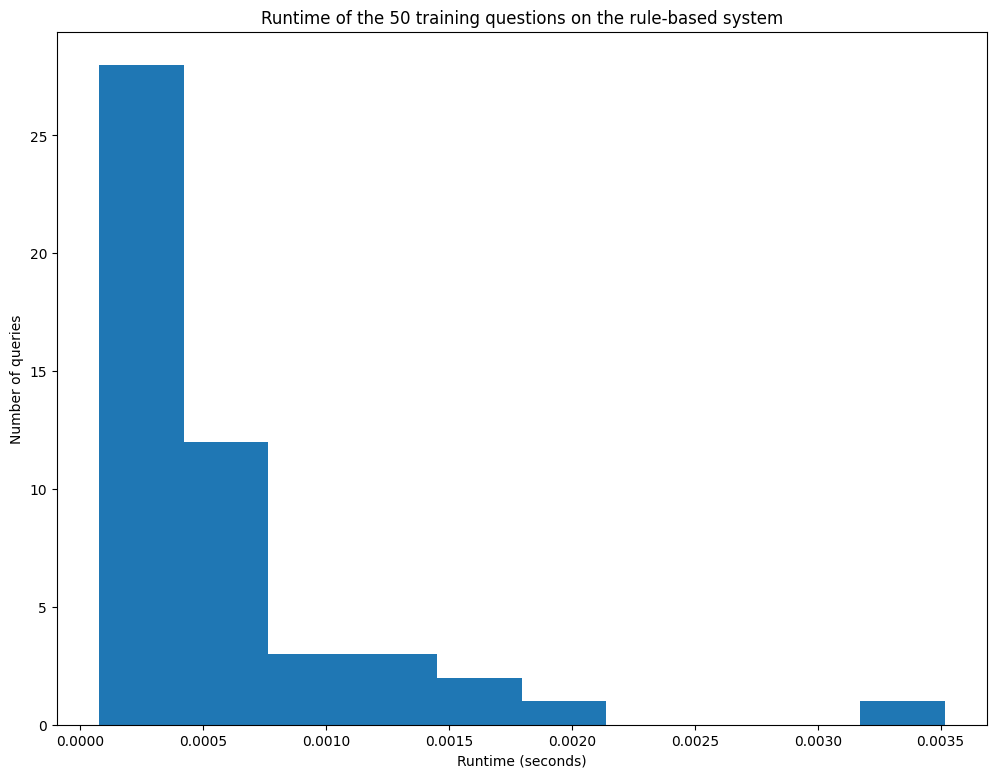

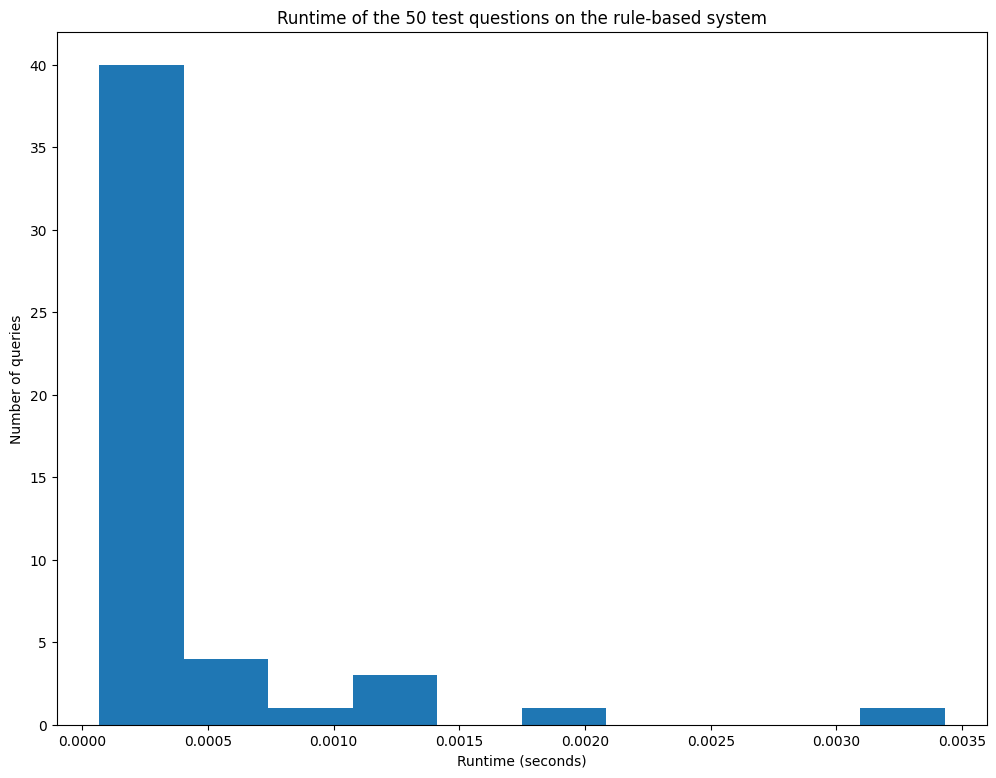

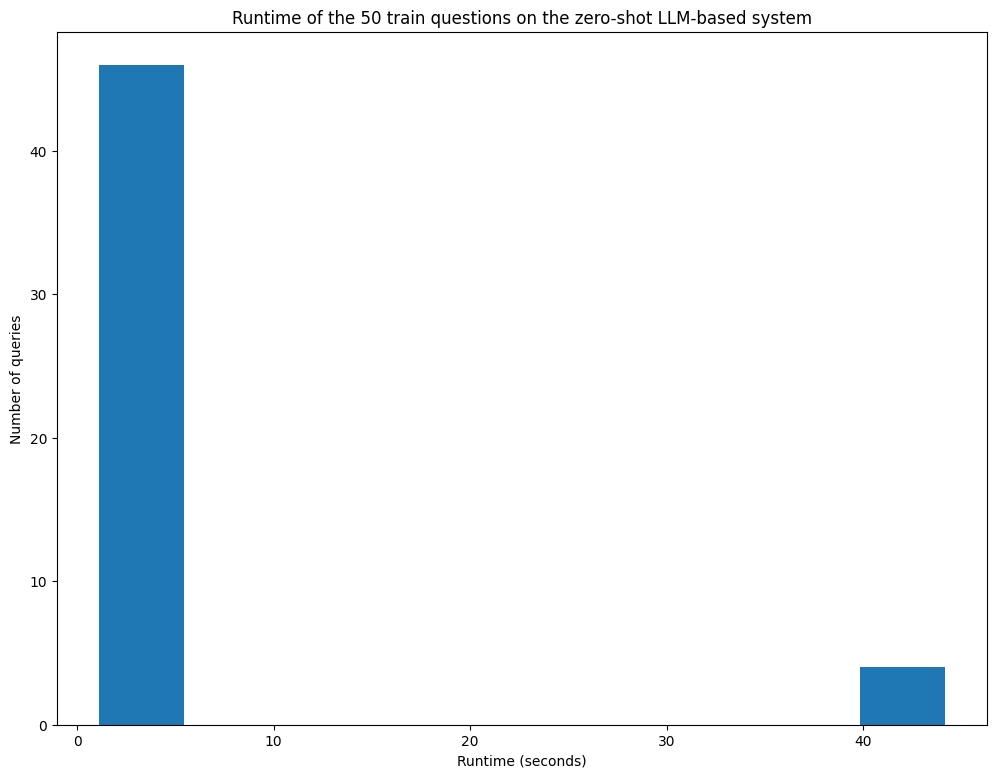

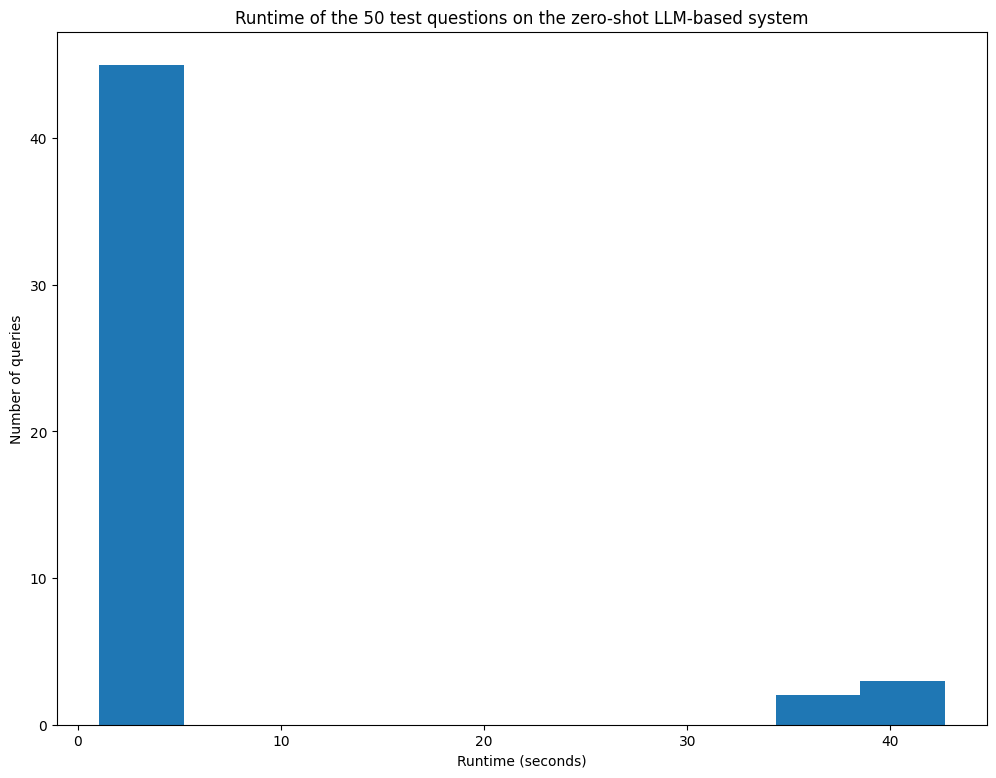

In [ ]:
plot_runtime(runtime_train_rule_based, 'Runtime of the 50 training questions on the rule-based system')
plot_runtime(runtime_test_rule_based, 'Runtime of the 50 test questions on the rule-based system')
plot_runtime(runtime_train_llm_based_zero_shot, 'Runtime of the 50 train questions on the zero-shot LLM-based system')
plot_runtime(runtime_test_llm_based_zero_shot, 'Runtime of the 50 test questions on the zero-shot LLM-based system')

In [ ]:
def scatter_plot_runtime(runtime: np.ndarray, title=None, yticks=None):
    fig, ax = plt.subplots(figsize=(12,9))
    ax.plot(np.arange(1,51), runtime, linestyle='--', marker='o')
    ax.set_title(title)
    ax.set_xlabel('Sample number', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_ylabel('Runtime (seconds)', fontsize=16)
    if yticks is not None:
        ax.set_yticks(yticks)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    plt.grid()
    plt.show()

In [ ]:
runtime_train_llm_based_zero_shot.mean()

np.float64(5.306659127200001)

/tmp/ipykernel_84664/1478351908.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
/tmp/ipykernel_84664/1478351908.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


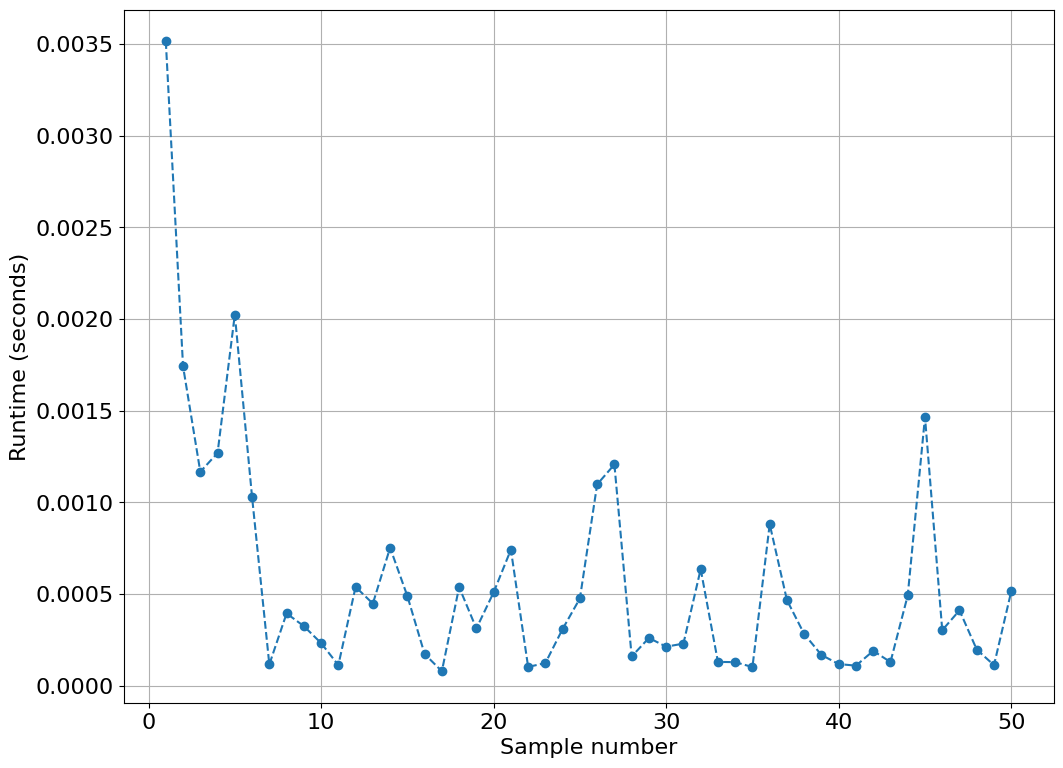

/tmp/ipykernel_84664/1478351908.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


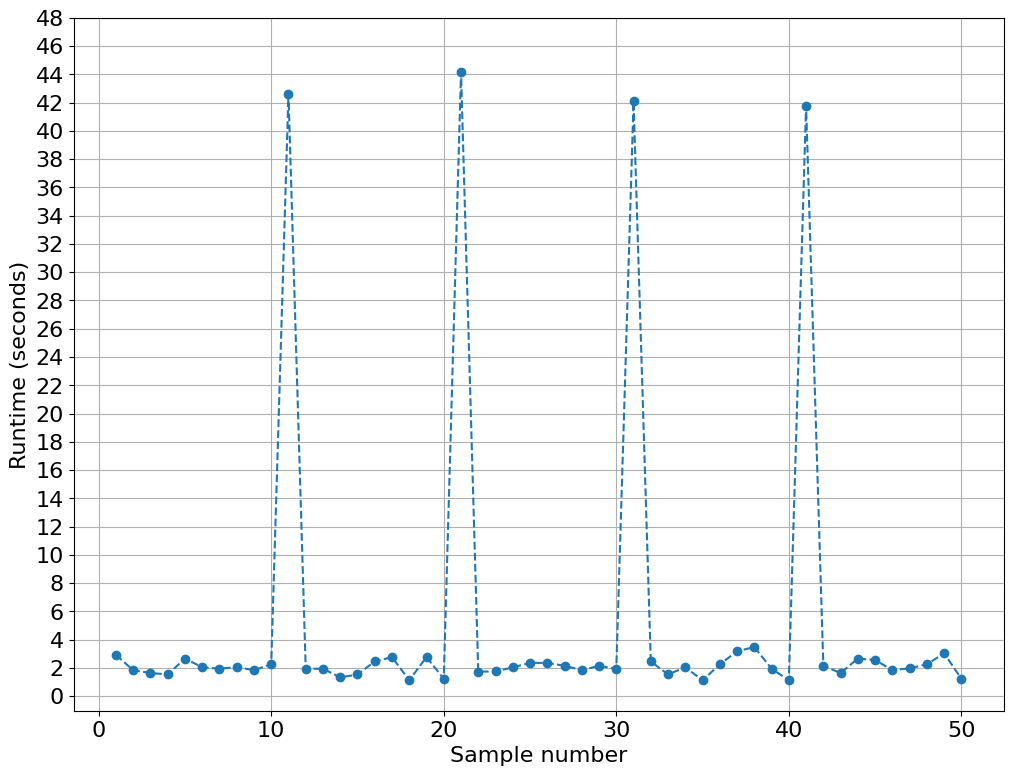

/tmp/ipykernel_84664/1478351908.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
/tmp/ipykernel_84664/1478351908.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


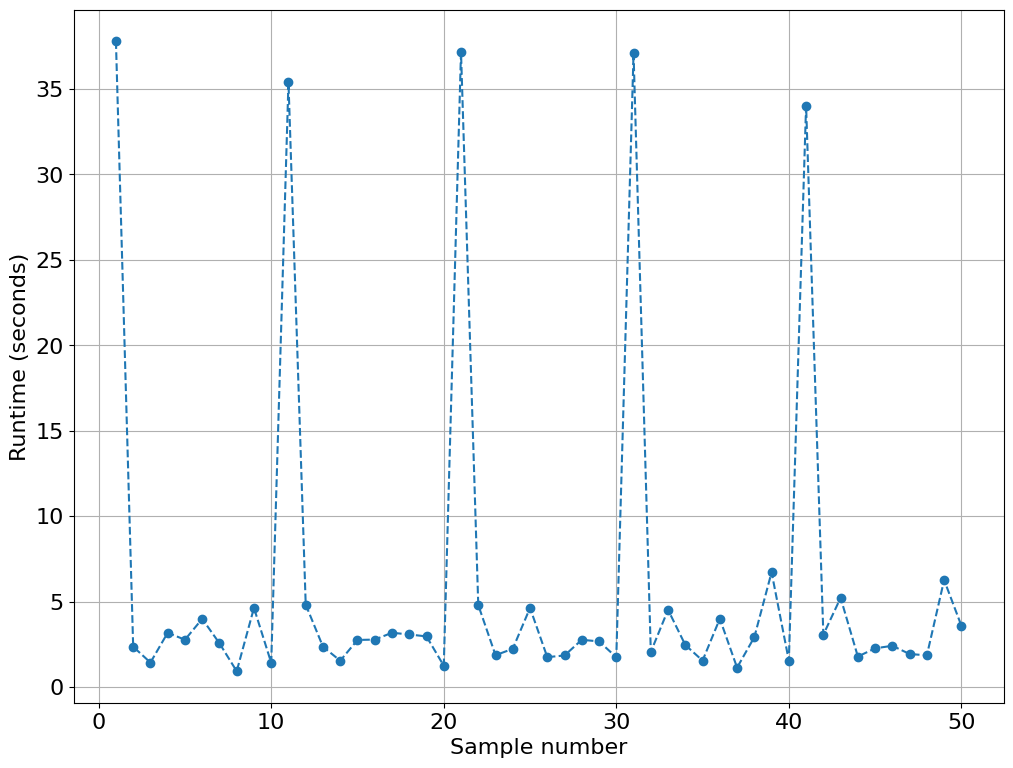

/tmp/ipykernel_84664/1478351908.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
/tmp/ipykernel_84664/1478351908.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


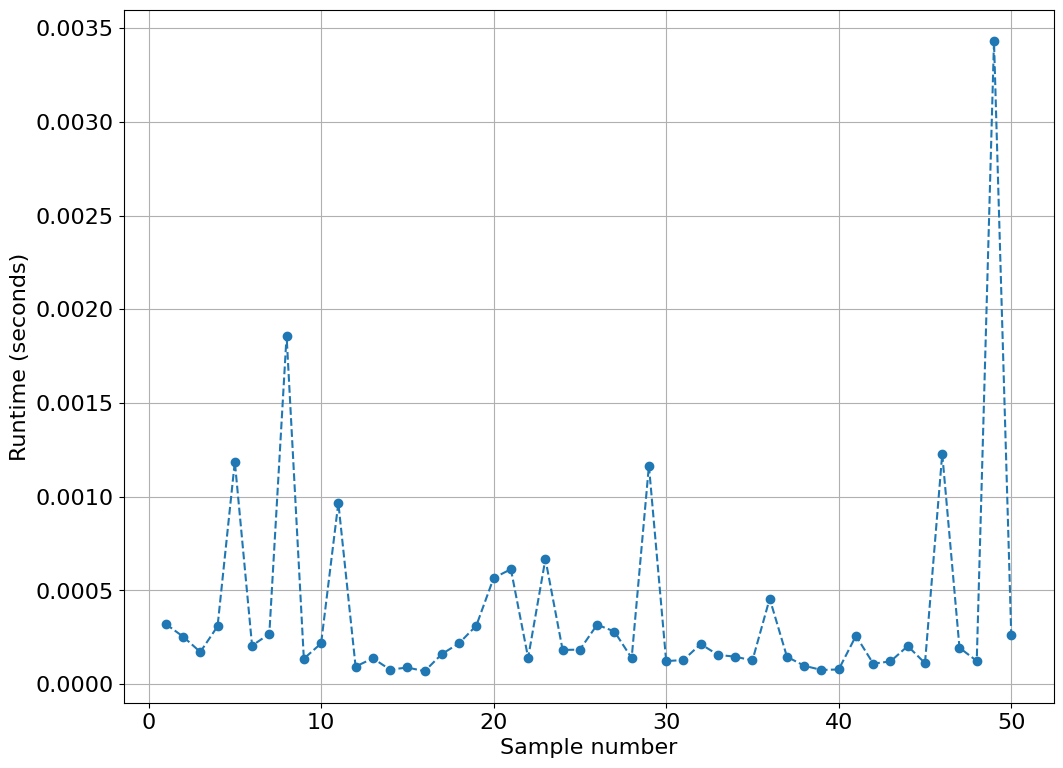

/tmp/ipykernel_84664/1478351908.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)


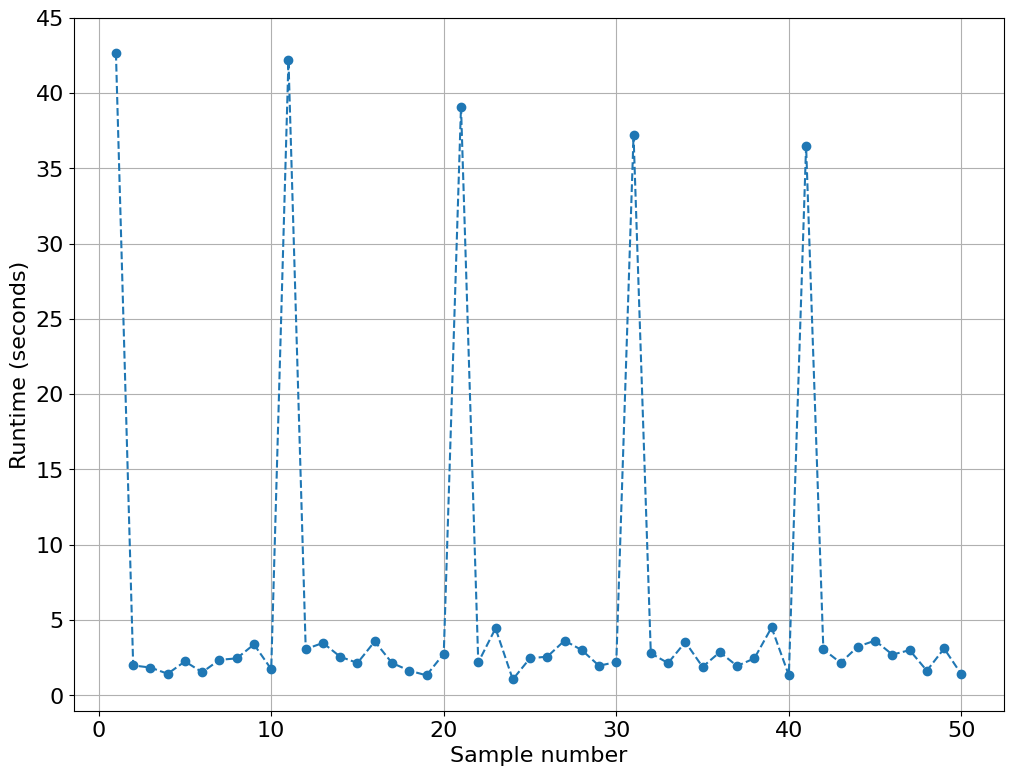

/tmp/ipykernel_84664/1478351908.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
/tmp/ipykernel_84664/1478351908.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


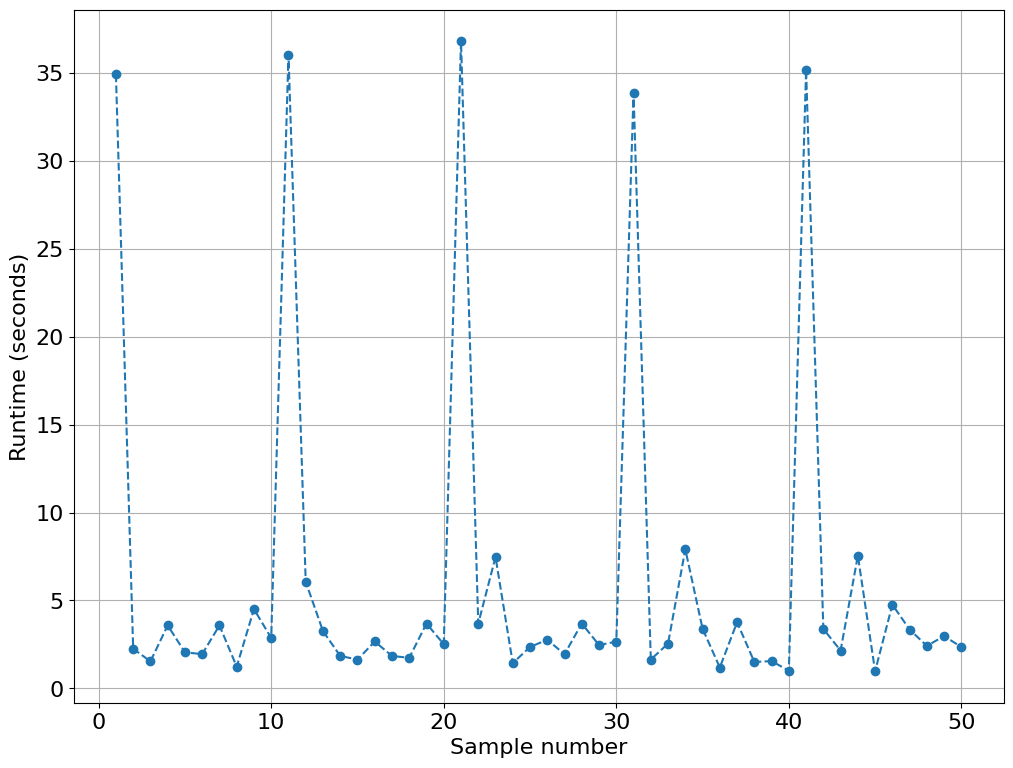

In [ ]:
scatter_plot_runtime(runtime_train_rule_based)
scatter_plot_runtime(runtime_train_llm_based_zero_shot, yticks=np.arange(0,50,2))
scatter_plot_runtime(runtime_train_llm_based_few_shot)
scatter_plot_runtime(runtime_test_rule_based)
scatter_plot_runtime(runtime_test_llm_based_zero_shot, yticks=np.arange(0,50,5))
scatter_plot_runtime(runtime_test_llm_based_few_shot)

In [ ]:
len('''
Jij bent een expert in SQL en jouw taak is om vragen geschreven in natuurlijke taal te vertalen naar geldige SQL queries. 
                           De database waarmee je werkt bevat de volgende SQL tabel:
                           ```sql
                           CREATE TABLE IF NOT EXISTS vulnerability (
                            cve VARCHAR(255),
                            title TEXT,
                            confidence INT,
                            severity VARCHAR(50), -- een van "informational", "low", "medium", "high" or "critical"
                            cvss DECIMAL(4,2), -- een decimaal getal tussen 0 en 10
                            epss DECIMAL(4,2),
                            cwe VARCHAR(255),
                            age INT, -- leeftijd van kwetsbaarheid in dagen
                            kev BOOLEAN
                           );
                           ```
                           Als je een vraag krijgt moet je die naar een SQL query vertalen die met de bovenstaande tabel moet werken. Als de vraag onbestaande kolomnamen bevat of als je de vraag niet kan vertalen, geef dat gewoon aan.
                           Maak geen nieuwe kolommen aan en veronstschuldig je niet.'''.split())

130

In [11]:
for question in test['questions']:
    print(cfg.vocabulary.filter_question_words(question))

CVE's 3
confidence 5
severity meer dan 5
CVE titel kwetsbaarheden 2 hoogste CVSS
age severity low
CVSS hoger dan 9 EPSS lager dan 0.1
CVE titel kwetsbaarheden 5
severity KEV
confidence
ouder dan gemiddelde leeftijd
CVE's EPSS hoger dan EPSS CVE
kwetsbaarheden
kwetsbaarheden leeftijd 7
severity
severity
titel
title
3 confidence
kwetsbaarheden waar confidence 100
CVE CVSS 2e hoogste CVSS
kwetsbaarheden CVE
kwetsbaarheden
CVE CVSS CVSS 7.0)
gemiddelde confidence
CWE's meer dan 5
confidence jongste
CVSS 5 4.5 5.5)
CVE's severity
CVSS severity 0.5
severity
CVE oudste severity KEV
KEV CVSS hoger dan 7

severity hoogste
confidence meer dan 2 EPSS
kwetsbaarheden severity
severity waar
gemiddelde CVSS
titel
confidence
KEV critical severity
CVE's oudste 5
gemiddelde leeftijd kwetsbaarheden CVSS hoger dan 8
kwetsbaarheden confidence 100 KEV
CWE's meer dan 5
waar severity cvss hoger dan 9

gemiddelde EPSS 2
bevat KEV waar
severity
